In [ ]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

# Alpha

In [ ]:
# Get images
image = img_to_array(load_img('0DEz7D.jpg'))
image = np.array(image, dtype=float)

In [ ]:
X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [ ]:
model.compile(optimizer='rmsprop', loss='mse')
model.fit(x=X, y=Y, batch_size=1, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 2/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.3382
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 8/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 12/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 13/1000
1/1 [==============================

In [ ]:
print(model.evaluate(X, Y, batch_size=1))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
imsave("img_result.png", lab2rgb(cur))
imsave("img_gray_version.png", rgb2gray(lab2rgb(cur)))

1/1 [==============================] - 0s 3ms/step - loss: 0.0072


0.007240296341478825


In [ ]:
! floyd run --data emilwallner/datasets/colornet/2:data --mode jupyter --tensorboard

/bin/bash: floyd: command not found


# Beta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls

drive  sample_data


In [ ]:
X = []
for filename in os.listdir('drive/My Drive/AutoEncoder/dataset/train'):
    X.append(img_to_array(load_img('drive/My Drive/AutoEncoder/dataset/train/'+filename)))
X = np.array(X, dtype=float)

# Set up training and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

# Finish model
model.compile(optimizer='rmsprop', loss='mse')

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model
TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=10000, epochs=1)
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print (model.evaluate(Xtest, Ytest, batch_size=batch_size))

# Load black and white images
color_me = []
for filename in os.listdir('../Test/'):
        color_me.append(img_to_array(load_img('../Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("result/img_"+str(i)+".png", lab2rgb(cur))

# Pytorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
from skimage import color

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time
import random

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd drive/My Drive/AutoEncoder/dataset/

/content/drive/My Drive/AutoEncoder/dataset


In [ ]:
import shutil
files = os.listdir('validate/')
for f in files[:500]:
  shutil.move(os.path.join('validate/', f), os.path.join('train/', f))

print(len(os.listdir('validate/')))

509


# Create Custom DataSet

In [ ]:
class AutoEncoderDataset(datasets.ImageFolder):
  def __init__(self, path, transforms = None, target_transforms = None):
    self.path = path
    self.transforms = transforms
    self.target_transforms = target_transforms

    self.images = os.listdir(self.path)
  
  def __getitem__(self, index):
    image_name = self.images[index]
    # read image
    image = io.imread(os.path.join(self.path,image_name), plugin = 'pil')
    # plt.imshow(image)

    # convert to LAB - gray, red-green, blue-yellow
    img_lab = color.rgb2lab(1.0/255*image)
    # range is -128 to 128, convert and normalize to 0-1
    # plt.imshow(img_lab[:, :, 0])
    # print(img_lab.shape)
    
    img_gray = img_lab[:, :, 0]
    img_ab = img_lab[:, :, 1:3]

    # print(img_gray.shape, img_ab.shape)

    # convert W x H x C into C x W x H
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

    # print(img_gray.shape, img_ab.shape)

    return img_gray, img_ab, image
  
  def __len__(self):
    return len(os.listdir(self.path))

# dataset = AutoEncoderDataset('train/')
# print(dataset[0])


In [ ]:
train_data = AutoEncoderDataset('train/')
val_data = AutoEncoderDataset('validate/')
test_data = AutoEncoderDataset('test/')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

# Create Model

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
            nn.Conv2d(1, 64, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3), padding = (1,1), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(128, 256, (3,3), padding = (1,1), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(256, 512, (3,3), padding = (1,1), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(512, 512, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(512, 256, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(256, 128, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor= (2,2)),
            nn.Conv2d(128, 64, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor= (2,2)),
            nn.Conv2d(64, 32, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(32, 2, (3,3), padding = (1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor= (2,2)),       
    )
  
  def forward(self, input):
    output = self.model(input)
    return output

In [ ]:
model = AutoEncoder()
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
e = 0

In [ ]:
print('Loading checkpoint')
checkpoint = torch.load('checkpoints/SGD 0.001/model-epoch-44-valloss-158.71756649017334.pt.tar')
model = AutoEncoder()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
e = checkpoint['epoch']
loss_func = nn.MSELoss()

Loading checkpoint


In [ ]:
! rm -r /content/outputs

In [ ]:
print(model)

In [ ]:
os.makedirs('/content/outputs/color', exist_ok=True)
os.makedirs('/content/outputs/target', exist_ok=True)
os.makedirs('/content/outputs/gray', exist_ok=True)
os.makedirs('/content/outputs/checkpoints', exist_ok=True)
os.makedirs('/content/outputs/tests', exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt
def save_image(gray, output, target, og_image, save_path, save_name):
  color_image = np.zeros((256,256,3))
  target_image = np.zeros((256,256,3))

  gray = gray.numpy()
  gray = gray.transpose((1,2,0))
  color_image[:, :, 0] = gray[:, :, 0]
  target_image[:, :, 0] = gray[:, :, 0]

  output = output.numpy()
  output = output.transpose((1,2,0))
  color_image[:, :, 1:] = output
  target = target.numpy()
  target = target.transpose((1,2,0))
  target_image[:, :, 1:] = target

  color_image = color.lab2rgb(color_image)
  target_image = color.lab2rgb(target_image)
  gray_image = color.rgb2gray(og_image)

  if save_path is not None and save_name is not None: 
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))
    plt.imsave(arr=target_image, fname='{}{}'.format(save_path['target'], save_name))
    plt.imsave(arr=gray_image, fname='{}{}'.format(save_path['grayscale'], save_name))

# Train

In [ ]:
def train(model, optimizer, loss_func, train_loader, val_loader, epochs, device = 'cpu'):
  model = model.to(device)
  loss_func = loss_func.to(device)
  training_loss = 0
  valid_loss = 0
  save_path = {'grayscale': '/content/outputs/gray/', 'colorized': '/content/outputs/color/',
               'target': '/content/outputs/target/'}

  for epoch in range(e+1, e+1+epochs):
    print('Starting epoch {}'.format(epoch))
    epoch_start = time.time()
    training_loss = 0.0
    valid_loss = 0.0

    model.train()
    b = 1
    for batch in train_loader:
      batch_start = time.time()
      optimizer.zero_grad()
      img_gray, img_ab, og_image = batch
      input, target = img_gray, img_ab
      input, target = input.to(device), target.to(device)
      output = model(input)
      loss = loss_func(output, target)
      loss.backward()
      optimizer.step()

      training_loss += loss.data.item()
      if b % 20 == 0:
        print('Epoch: {} , Batch: {} Training Loss: {:.4f}, Time: {:.2f}'.format(
        epoch, b, loss.data.item(), time.time() - batch_start))
      b += 1

    training_loss /= len(train_loader)

    model.eval()
    b = 1
    for batch in val_loader:
      batch_start = time.time()
      img_gray, img_ab, og_image = batch
      input, target = img_gray, img_ab
      input, target = input.to(device), target.to(device)
      output = model(input)
      loss = loss_func(output, target)

      valid_loss += loss.data.item()

      if epoch % 5 == 0:
        j = random.randint(1,9)
        save_name = 'epoch-{}batch-{}img-{}.jpg'.format(epoch, b, j)
        save_image(input[j].detach().cpu(), output[j].detach().cpu(), target[j].detach().cpu(),
                  og_image[j].detach().cpu(), save_path=save_path, save_name=save_name)
          
      print('Epoch: {} , Batch: {} Valid Loss: {:.4f}, Time: {:.2f}'.format(
      epoch, b, loss.data.item(), time.time() - batch_start))

      b += 1
    valid_loss /= len(val_loader)

    c_path = 'checkpoints/model-epoch-{}-valloss-{}.pt.tar'.format(epoch, valid_loss)
    if epoch % 10 == 0:
      save_checkpoint = {'epoch': epoch,
                         'state_dict': model.state_dict(),
                         'optimizer' : optimizer.state_dict(),
                         }
      torch.save(save_checkpoint, c_path)
  
    print('Epoch: {} , Training Loss: {:.4f}, Validation Loss: {:.4f}, Time: {:.2f}'
    .format(epoch, training_loss, valid_loss, time.time() - epoch_start))

In [ ]:
if use_gpu:
  device = 'cuda'
else:
  device = 'cpu'
train(model, optimizer, loss_func, train_loader, val_loader, 100, device)

Starting epoch 45
Epoch: 45 , Batch: 20 Training Loss: 94.9545, Time: 1.29
Epoch: 45 , Batch: 40 Training Loss: 143.1237, Time: 1.30
Epoch: 45 , Batch: 60 Training Loss: 119.1924, Time: 1.31
Epoch: 45 , Batch: 80 Training Loss: 188.3134, Time: 1.36
Epoch: 45 , Batch: 100 Training Loss: 116.5901, Time: 1.29
Epoch: 45 , Batch: 120 Training Loss: 221.1850, Time: 1.39
Epoch: 45 , Batch: 140 Training Loss: 206.0549, Time: 1.36
Epoch: 45 , Batch: 160 Training Loss: 102.6847, Time: 1.41
Epoch: 45 , Batch: 180 Training Loss: 133.7316, Time: 1.23
Epoch: 45 , Batch: 200 Training Loss: 164.0790, Time: 1.34
Epoch: 45 , Batch: 220 Training Loss: 112.4689, Time: 1.27
Epoch: 45 , Batch: 240 Training Loss: 170.8378, Time: 1.37
Epoch: 45 , Batch: 260 Training Loss: 160.5222, Time: 1.26
Epoch: 45 , Batch: 1 Valid Loss: 137.8229, Time: 0.66
Epoch: 45 , Batch: 2 Valid Loss: 172.4938, Time: 0.65
Epoch: 45 , Batch: 3 Valid Loss: 130.2623, Time: 0.74
Epoch: 45 , Batch: 4 Valid Loss: 155.5229, Time: 0.68
Epoc

# Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


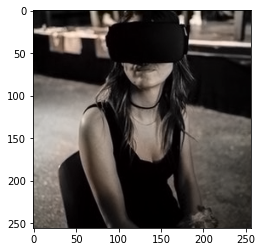

In [ ]:
image = io.imread('train/ZZwpD8.jpg')
# plt.imshow(image)
img_lab = color.rgb2lab(1.0/255*image)
img_gray = img_lab[:, :, 0]
# plt.imshow(img_gray)
img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
img_ab = img_lab[:, :, 1:3]
img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

img_gray = img_gray.cuda()
img_ab = img_ab.cuda()

predict = model(img_gray.unsqueeze(0))

color_image = np.zeros((256,256,3))

# plt.imshow(color_image)

img_gray = img_gray.detach().cpu().numpy()
img_gray = img_gray.transpose((1,2,0))

# plt.imshow(img_gray[:, :, 0])

color_image[:, :, 0] = img_gray[:, :, 0]

# plt.imshow(color_image)

predict = predict.detach().cpu().numpy()[0]
print(predict.shape)
predict = predict.transpose((1,2,0))
color_image[:, :, 1:] = predict

plt.imshow(color_image)
plt.imshow(color.lab2rgb(color_image))

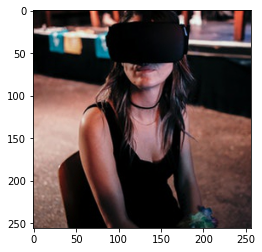

In [ ]:
from skimage import io, color
image = io.imread('train/ZZwpD8.jpg')
# plt.imshow(image)

img_lab = color.rgb2lab(1.0/255*image)
# plt.imshow(img_lab)


img_gray = img_lab[:, :, 0]
# plt.imshow(img_gray)

img_ab = img_lab[:, :, 1]
# plt.imshow(img_ab)

img_ab = img_lab[:, :, 2]
# plt.imshow(img_ab)

img_ab = img_lab[:, :, 1:3]

# img_ab /= 128 # NO NEEDDEEDD
# plt.imshow(img_ab)

col = np.zeros((256,256,3))
col[:, :, 0] = img_gray

# plt.imshow(col)

col[:, :, 1:] = img_ab

# plt.imshow(col)

image = color.lab2rgb(col)
plt.imshow(image)

# GPU check

In [ ]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=e0df608a8544cf08a1ce725644114d293048cc7fd4aba0668804ffac64d4c545
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.4 GB  | Proc size: 2.0 GB
GPU RAM Free: 11033MB | Used: 408MB | Util   4% | Total 11441MB


In [ ]:
torch.cuda.empty_cache()